In [1]:
## Data can be downloaded from: http://archive.ics.uci.edu/ml/machine-learning-databases/00235/
## Just open the zip file and grab the file 'household_power_consumption.txt' put it in the directory 
## that you would like to run the code. 

import pandas as pd
import numpy as np
import time

df = pd.read_csv('household_power_consumption.txt', sep=';', 
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True, 
                 low_memory=False, na_values=['nan','?'], index_col='dt')

In [2]:
df.shape

(2075259, 7)

In [3]:
df.head()

Global_active_power  Global_reactive_power  Voltage  \
dt                                                                         
2006-12-16 17:24:00                4.216                  0.418   234.84   
2006-12-16 17:25:00                5.360                  0.436   233.63   
2006-12-16 17:26:00                5.374                  0.498   233.29   
2006-12-16 17:27:00                5.388                  0.502   233.74   
2006-12-16 17:28:00                3.666                  0.528   235.68   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
dt                                                                      
2006-12-16 17:24:00              18.4             0.0             1.0   
2006-12-16 17:25:00              23.0             0.0             1.0   
2006-12-16 17:26:00              23.0             0.0             2.0   
2006-12-16 17:27:00              23.0             0.0             1.0   
2006-12-16 17:28:00              15.8             0.0             1.0   

                     Sub_metering_3  
dt                                   
2006-12-16 17:24:00            17.0  
2006-12-16 17:25:00            16.0  
2006-12-16 17:26:00            17.0  
2006-12-16 17:27:00            17.0  
2006-12-16 17:28:00            17.0

# Clean data

In [4]:
## finding all columns that have nan:
droping_list_all=[]
for j in range(0,7):
    if not df.iloc[:, j].notnull().all():
        droping_list_all.append(j)        
        #print(df.iloc[:,j].unique())
droping_list_all

# filling nan with mean in any columns
for j in range(0,7):        
        df.iloc[:,j]=df.iloc[:,j].fillna(df.iloc[:,j].mean())
        
# sanity check to make sure that there are not more any nan
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [5]:
from sklearn.preprocessing import MinMaxScaler
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	dff = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(dff.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(dff.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

## resampling of data over hour
df_resample = df
df_resample.shape

values = df_resample.values
## full data without resampling
#values = df.values

# integer encode direction
# ensure all data is float
#values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[8,9,10,11,12,13]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.374796   0.300719   0.376090   0.377593        0.0     0.0125   
2   0.478363   0.313669   0.336995   0.473029        0.0     0.0125   
3   0.479631   0.358273   0.326010   0.473029        0.0     0.0250   
4   0.480898   0.361151   0.340549   0.473029        0.0     0.0125   
5   0.325005   0.379856   0.403231   0.323651        0.0     0.0125   

   var7(t-1)   var1(t)  
1   0.548387  0.478363  
2   0.516129  0.479631  
3   0.548387  0.480898  
4   0.548387  0.325005  
5   0.548387  0.311787  


In [6]:
reframed.describe()

var1(t-1)     var2(t-1)     var3(t-1)     var4(t-1)     var5(t-1)  \
count  2.075258e+06  2.075258e+06  2.075258e+06  2.075258e+06  2.075258e+06   
mean   9.194415e-02  8.900326e-02  5.699470e-01  9.186223e-02  1.274913e-02   
std    9.511640e-02  8.058576e-02  1.040273e-01  9.162845e-02  6.948180e-02   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    2.118414e-02  3.453237e-02  5.111470e-01  2.489627e-02  0.000000e+00   
50%    5.015390e-02  7.338129e-02  5.738288e-01  5.394191e-02  0.000000e+00   
75%    1.307261e-01  1.381295e-01  6.352181e-01  1.286307e-01  0.000000e+00   
max    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   

          var6(t-1)     var7(t-1)       var1(t)  
count  2.075258e+06  2.075258e+06  2.075258e+06  
mean   1.623151e-02  2.083371e-01  9.194401e-02  
std    7.231840e-02  2.704574e-01  9.511620e-02  
min    0.000000e+00  0.000000e+00  0.000000e+00  
25%    0.000000e+00  0.000000e+00  2.118414e-02  
50%    0.000000e+00  3.225806e-02  5.015390e-02  
75%    1.250000e-02  5.483871e-01  1.307261e-01  
max    1.000000e+00  1.000000e+00  1.000000e+00

# Split X and y (#2075258)

In [7]:
reframed.shape

(2075258, 8)

In [8]:
X = reframed.iloc[:, 0:7].values
y = reframed.iloc[:, 7].values

In [9]:
def FindBeta(X, y, lamda):
    t1_start = time.perf_counter()
    t2_start = time.process_time()
    p = X.shape[1]
    n = X.shape[0]

    I = np.eye(p, dtype=int)
    X_T = np.transpose(X)
    inver = np.linalg.inv(np.dot(X_T, X) + n*lamda*I)
    beta = np.dot(np.dot(inver, X_T), y)
    t1_stop = time.perf_counter()
    t2_stop = time.process_time()
    t1 = t1_stop-t1_start
    t2 = t2_stop-t2_start
    #print("Elapsed time: %.5f [seconds]" % t1)
    #print("CPU process time: %.5f [seconds]" % t2)
    
    return [beta, t1, t2]

In [10]:
def RepeatFindBeta(r, X, y, lamda):
    t = []
    for i in range(r):
        beta, t1, t2 = FindBeta(X, y, lamda)
        t.append([t1, t2])
    return np.average(t, axis=0)

In [11]:
beta, t1_1, t2_1  = FindBeta(X, y, 1)
beta

array([0.0140604 , 0.00740605, 0.03274807, 0.01375889, 0.00370062,
       0.00377032, 0.02737883])

In [12]:
t2_1

0.450765999999998

# Split X and y (#1994)

In [13]:
X_1 = reframed.iloc[0:1994, 0:7].values
y_1 = reframed.iloc[0:1994, 7].values

In [14]:
beta_1 = FindBeta(X_1, y_1, 1)
beta_1

[array([0.03851587, 0.01440459, 0.06292208, 0.03788225, 0.00361416,
        0.00783164, 0.05469515]), 0.0009540890000003799, 0.004310000000000258]

# Scalability

In [15]:
factor = np.arange(1,1040)
list = [x*1994 for x in factor]

In [16]:
# Elapsed time & CPU time
t = []
# set repeat times
rep = 10

for i in list:
    X = reframed.iloc[:i, 0:7].values
    y = reframed.iloc[:i, 7].values
    t_t = RepeatFindBeta(rep, X, y, 1)
    t.append(t_t)

t = np.array(t) # change to np.array for slicing

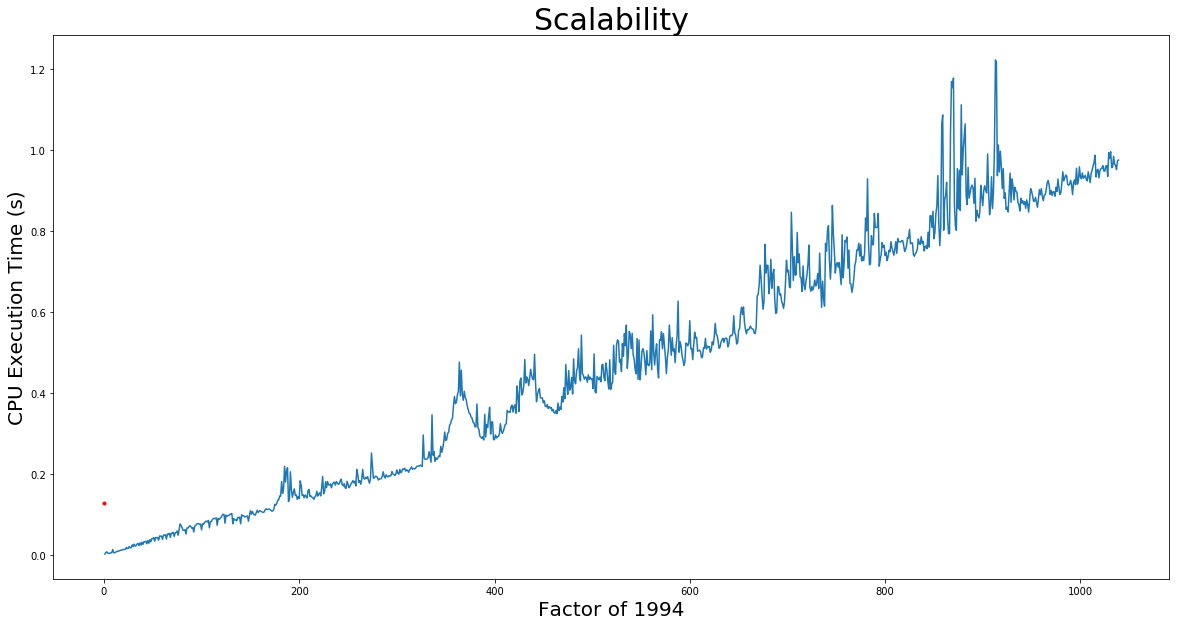

In [20]:
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10
plt.plot(factor, t[:,1])
plt.plot(0, 0.1286, marker='o', markersize=3, color='red')
#plt.legend(fontsize=20, loc='right')
plt.title('Scalability', fontsize = 30)
plt.xlabel('Factor of 1994', fontsize = 20)
plt.ylabel('CPU Execution Time (s)', fontsize = 20)
plt.show()

In [18]:
# Elapsed time & CPU time
t1 = []
for i in list_1:
    X = reframed.iloc[:i, 0:7].values
    y = reframed.iloc[:i, 7].values
    t_t = RepeatFindBeta(rep, X, y, 1)
    t1.append(t_t)
    t1 = np.array(t1)

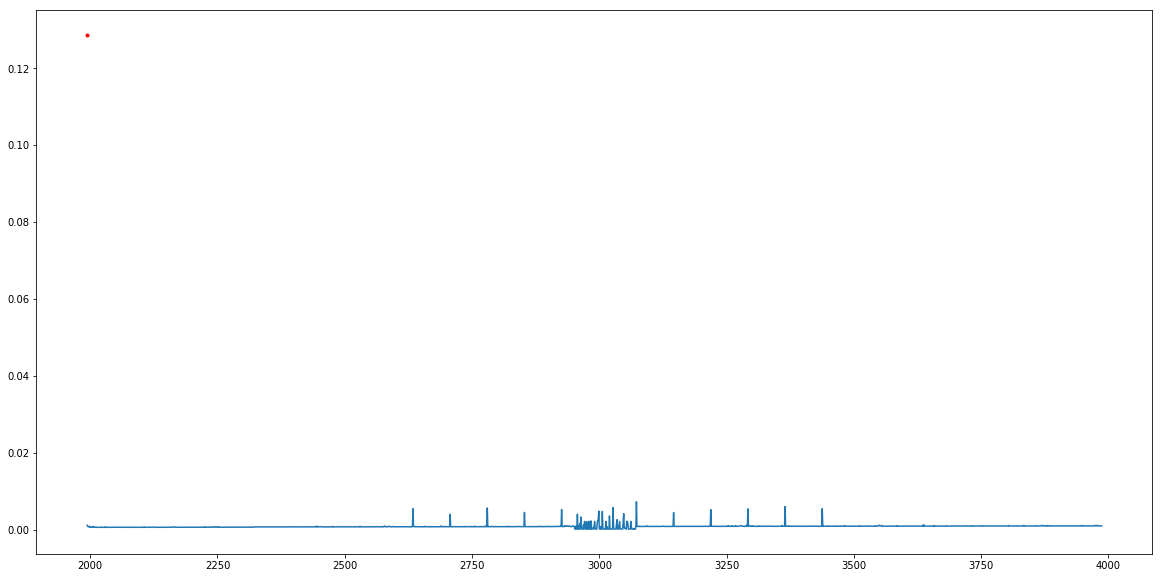

In [32]:
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10
plt.plot(list_1, t1[:, 1])
plt.plot(1994, 0.1286, marker='o', markersize=3, color='red')
plt.show()